# Śledzenie rozgrywki bilarda
## Autorzy: Joanna Adamczyk, Piotr Kamiński

## Import niezbędnych bibliotek

In [129]:
%matplotlib inline
import numpy as np
import cv2

from ipywidgets import Video

import PIL
from IPython.display import display

def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

## Analiza wideo

### Wczytanie wideo i jego podstawowych właściwości

In [130]:
video = cv2.VideoCapture('movies/video3.mov')
if video.isOpened():
    print('Movie loaded')

width = int(video.get(3))
height = int(video.get(4))
print(f'Height and width of the video: {height} x {width}')

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Number of frames per second: {fps}')

Movie loaded
Height and width of the video: 1194 x 2144
Number of frames per second: 59.869565217391305


### Wyświetlenie przykładowego wideo

In [131]:
Video.from_file('movies/video3.mov')

Video(value=b'\x00\x00\x00\x14ftypqt  \x00\x00\x00\x00qt  \x00\x00\x00\x08wide\x00p\xb5\xa5mdat\x00\x00\x00\x1…

## Algorytmy analizy rozgrywki bilarda

### Funkcje pomocnicze

In [132]:
# Funkcja generująca bbox z współrzędnych środka okręgu i jego promienia
def circle_to_rectangle(circle, radius):
    return (int(circle[0]-radius), int(circle[1]-radius), int(2*radius),  int(2*radius))

# Funkcja rysująca prostokąt z bboxa (x1, x2, width, height)
def draw_bbox(frame, bbox, color=(255, 255, 255)):

    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)

# Funkcja wycinający wybrany obszar z obrazu
def crop_circle(frame, circle):
    bbox = circle_to_rectangle(circle, circle[2])
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    return frame[p1[1]:p2[1], p1[0]:p2[0]]

# Funkcja licząca długość wektora
def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Funkcja licząca prędkość bili
def calculate_velocity(x, y, fps, n_frames):
  return np.sqrt(x**2 + y**2)/(n_frames/fps)

# Funkcja wykrywająca kolizję
def collision(c1, c2, v1, v2, max_pos_tol):

    dp = v1[0] * v2[0] + v1[1] + v2[1]

    if distance(c1, c2) < max_pos_tol and dp > 0:
        return True

    return False

# Funkcja licząca centroid z punktów bboxa
def count_centroid(b):
    return [ int(b[0] + b[2]/2), int(b[1] + b[3]/2) ]

# Funckja znajdująca małe okręgi na obrazie
def find_circles(frame, max_r, min_r):

    filter = np.array([
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1]
    ]) 

    sharpen_img_1 = cv2.filter2D(frame, -1, filter)
    cimg = cv2.cvtColor(sharpen_img_1, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT, 1, 2 * min_r, param1 = 60, 
                param2 = 20, minRadius = min_r, maxRadius = max_r)
    
    circles = np.uint16(np.around(circles))
    
    return circles

# Funkcja rysująca centroidy 
def draw_points(frame, points, radius, thickness):

    for p in points:
        cv2.circle(frame, p, radius, (0, 0, 0), thickness)

# Funkcja znajdująca łuzy na obrazie
def find_pocket(frame):

    filter = np.array([
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1]
    ]) 
    
    sharpen_img_1 = cv2.filter2D(frame, -1, filter)
    cimg = cv2.cvtColor(sharpen_img_1, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(cimg,7)
    circles_blur = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT,1,frame.shape[0]/3,
                            param1=60,param2=20,minRadius=35,maxRadius=50)
    pockets = np.uint16(np.around(circles_blur))

    return pockets

# Funkcja sprawdzająca, czy bila jest w łuzie
def in_pocket(bill_pos, pocket_pos, pocket_r):

    dist = distance(bill_pos.astype(np.float32), pocket_pos.astype(np.float32))
    if dist < pocket_r:
        return True
    
    return False

# Granice poszczególnych kolorów bili w przestrzeni kolorów HSV
boundaries = {
    'white' : [[0,0,245], [179,104,255]],
    'yellow' : [[13,60,96], [51,255,255]],
    'blue' : [[108,48,80], [131,255,218]],
    'green' : [[34,68,75], [99,255,183]],
    'pink' : [[153,160,0], [173,255,255]],
    'purple' : [[119,48,71], [157,215,229]],
    'brown' : [[0,168,0], [16,255,168]],
    'red' : [[148,196,0], [179,255,255]],
    'black' : [[0,0,0], [179,255,85]]
}

# Funkcja licząca zawartość procentową koloru w obrazie
def color_percentage(frame, lower, upper):
    
    grid_RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    grid_HSV = cv2.cvtColor(grid_RGB, cv2.COLOR_RGB2HSV) 
    mask= cv2.inRange(grid_HSV, np.array(lower), np.array(upper))
    
    return (mask>0).mean()*100

# Funkcja pozyskująca klucz i wartość dla maksymalnej wartości w słowniku
def keywithmaxval(d):
     
     v = list(d.values())
     k = list(d.keys())
     maximum = (max(v))
     return  (k[v.index(maximum)],maximum)

# Funkcja znajdująca bile oraz ich kolory
def find_colours(frame, max_r, min_r):

    filter = np.array([
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1]
    ]) 

    sharpen_img_1 = cv2.filter2D(frame, -1, filter)
    cimg = cv2.cvtColor(sharpen_img_1, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT, 1, 2 * min_r, param1 = 60, 
                param2 = 20, minRadius = min_r, maxRadius = max_r)
    
    circles = np.uint16(np.around(circles))
    not_bills = []
    bill_colours = []

    for idx, i in enumerate(circles[0,:]):
        cropped = crop_circle(frame, i)
        colours = {
            'white' : 0.0,
            'yellow' : 0.0,
            'blue' : 0.0,
            'green' : 0.0,
            'pink' : 0.0,
            'purple' : 0.0,
            'brown' : 0.0,
            'red' : 0.0,
            'black' : 0.0,
        }
        bill = False
        for key, value in boundaries.items():
            percentage = color_percentage(cropped, value[0], value[1])
            colours[key] = percentage
        k, v = keywithmaxval(colours)
        if (v > 30):
            if k == 'black' or k == 'yellow':
                if (colours['black'] > 30) and colours['yellow'] > 10:
                    bill_colours.append('black_yellow')
                    bill = True
                else:
                    bill_colours.append(k)
                    bill = True
            else:
                bill_colours.append(k)
                bill = True
        if bill == False:
            not_bills.append(idx)


    circles = np.delete(circles[0], not_bills, axis=0)[np.newaxis]

    for idx, i in enumerate(circles[0,:]):
        cv2.circle(frame, (i[0], i[1]), i[2], (0,255,0), 2)
    
    return circles, bill_colours

# Słownik zawierający wartości bil odpowiadające poszczególnym kolorom
points = {
            'white' : 0,
            'yellow' : 1,
            'blue' : 2,
            'red' : 3,
            'purple' : 4,
            'pink' : 5,
            'green' : 6,
            'brown' : 7,
            'black' : 8,
            'black_yellow' : 9,
        }

### Poszukiwanie współrzędnych bil, łuz oraz obszaru stołu na obrazie

Do znaleznienia bil wykorzystaliśmy transformatę Hough'a wyszukującą okręgi. Po dobraniu odpowiednich parametrów udało się wykrywać bile. Do znalezienia łuz użyliśmy tej samej metody lecz z innymi parametrami (większy promień okręgu). Do wykrycia obszaru stołu skorzystalismy z współrzędnych centroidów wykrytych łuz.

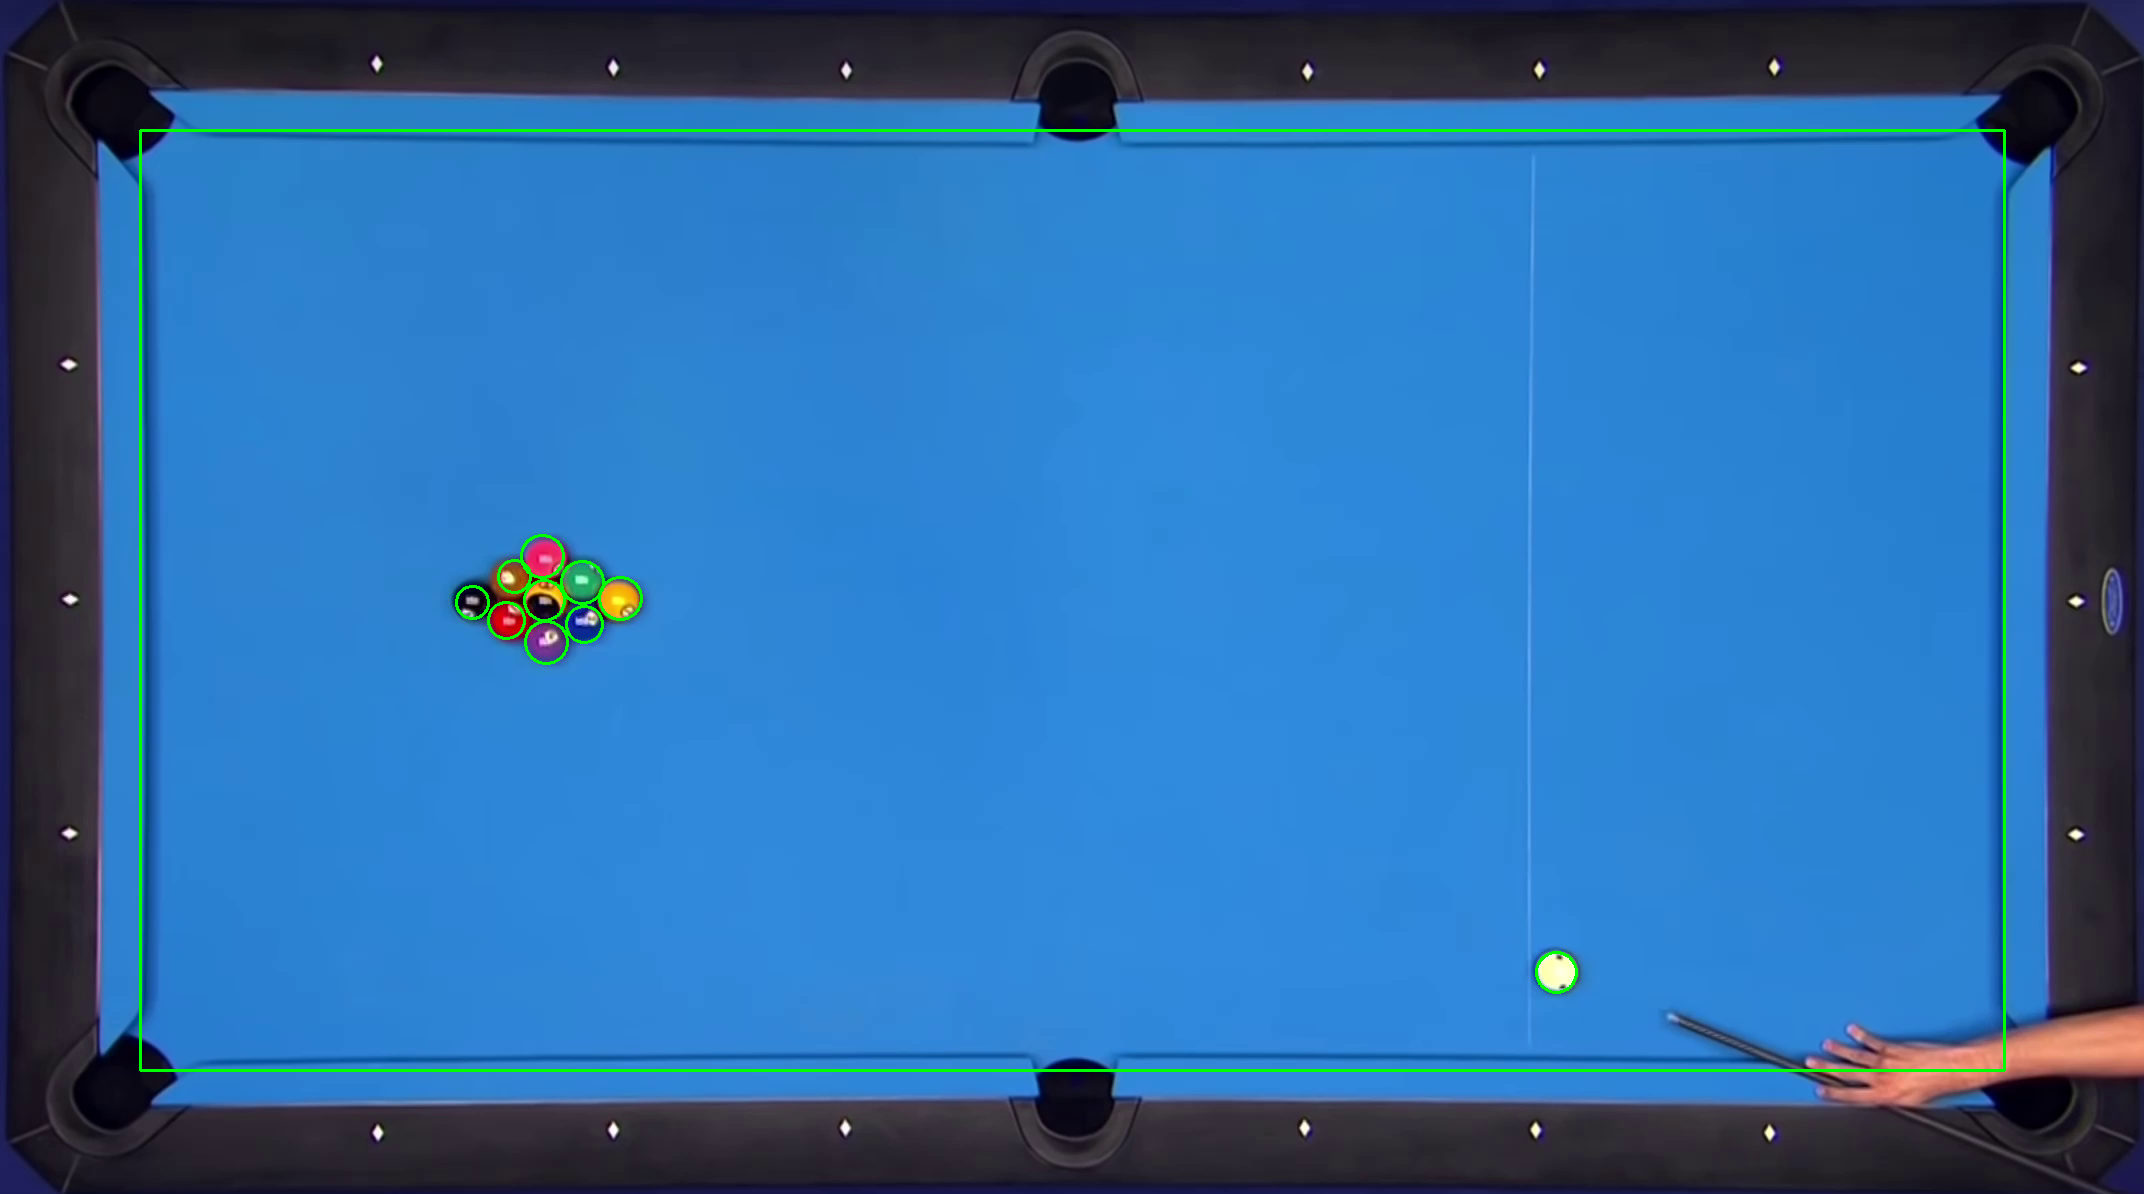

In [133]:
ret, frame = video.read()

pockets = find_pocket(frame)

p1 = (np.min(pockets[0], axis=0)[0]+30, np.min(pockets[0], axis=0)[1]+30)
p2 = (np.max(pockets[0], axis=0)[0]-30, np.max(pockets[0], axis=0)[1]-30)

cv2.rectangle(frame, p1, p2, (0,255,0), 2, 1)

bills, bill_colours = find_colours(frame,22,14)


imshow(frame)

### Wykorzystanie algorytmu CSRT do śledzenia znalezionych bili

Do śledzenia znalezionych bili po testach zdecydowaliśmy się na skorzystanie z trackera CSRT.

In [134]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.legacy.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.legacy.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.legacy.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.legacy.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.legacy.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.legacy.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.TrackerCSRT_create()


### Wykrywanie zderzenia

Do wykrywania kolizji skorzystaliśmy wartości dystansu pomiędzy bilami, jeśli ten jest mniejszy od ustalonego progu oraz jeśli iloczyn skalarny jest większy od zera.

In [135]:
video = cv2.VideoCapture('movies/video4.mov')
if video.isOpened():
    print('Movie loaded')

width = int(video.get(3))
height = int(video.get(4))
fps = video.get(cv2.CAP_PROP_FPS)

Movie loaded


In [136]:
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = video.read()

HISTORY = 5
MOV_TOLERANCE = 3
MAX_POS_TOL = None
MIN_DEG_TOL = np.pi/6

ANALYZE_FROM = 0
ANALYZE_TO = np.inf

circles = find_circles(frame, 21, 13)
avg_r = np.average(circles[0, :, 2])

bills = []

for c in circles[0]:
    bills.append(create_tracker('CSRT'))
    bills[-1].init(frame, circle_to_rectangle(c, avg_r + 10))

MAX_POS_TOL = 3.5 * avg_r

video_tracker = cv2.VideoWriter('video_tracker_collision.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

frames_number = 0

collisions = []
last_frames_pos = np.zeros((HISTORY,len(bills),  2), dtype=np.int32)
last_frames_v = np.zeros((HISTORY, len(bills),  2), dtype=np.int32)

pos = np.zeros((len(bills), 2), dtype=np.int32)
vel = np.zeros((len(bills),2 ), dtype=np.int32)

for idx, b in enumerate(bills):
    _, bbox = b.update(frame)
    pos[idx] = count_centroid(bbox)

last_frames_pos = last_frames_pos + pos

while video.isOpened():

    frames_number += 1
    ret, frame = video.read()
    
    if ret and frames_number < ANALYZE_TO - ANALYZE_FROM:

        bbox = None
        for idx, b in enumerate(bills):
            ok, bbox = b.update(frame)
            if ok: draw_bbox(frame, bbox, (0, 255, 0))

            pos[idx] = count_centroid(bbox)

        for idx, b in enumerate(bills):
            dist = distance(pos[idx], last_frames_pos[0][idx])
            if dist > MOV_TOLERANCE:
                
                vel[idx] = np.array([
                    pos[idx][0] - last_frames_pos[0][idx][0], pos[idx][1] - last_frames_pos[0][idx][1]
                ]) / (HISTORY/fps)
            else:
                vel[idx] = np.array([0,0])

            # jeśli chcemy rysować wektory prędkości bil
            # cv2.line(frame, pos[idx], (pos[idx] + np.average(last_frames_v[:, idx], axis=0)/6).astype(np.int32), (255, 0, 0), thickness=2)

        last_frames_pos = np.concatenate([last_frames_pos, [pos.copy()]], axis=0)
        last_frames_v = np.concatenate([last_frames_v, [vel.copy()]], axis=0)

        last_frames_pos = np.delete(last_frames_pos, 0, axis=0)
        last_frames_v = np.delete(last_frames_v, 0, axis=0)

        bill_pos = last_frames_pos[-1][0]
        bill_v = last_frames_v[-1][0]


        for i in range(len(bills) - 1):
            for j in range(i + 1, len(bills)):

                b1 = pos[i]
                b2 = pos[j]
                v1 = vel[i]
                v2 = vel[j]

                if collision(b1, b2, v1, v2, MAX_POS_TOL):
                    collisions.append([
                        frames_number, 
                    ])
                    for k in range(20):
                
                        cv2.putText(frame, 'COLLISION', b1 + 40, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        video_tracker.write(frame)

        video_tracker.write(frame)
    else:
        break

video_tracker.release()

In [137]:
!ffmpeg -hide_banner -loglevel error -i video_tracker_collision.avi -y video_tracker_collision.mp4
Video.from_file('video_tracker_collision.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0e\xf0\x9cmdat\x0…

## Śledzenie punktacji

Do śledzenia punktacji skorzystaliśmy z analizy kolorystycznej. Podczas analizy pierwszej klatki identyfikujemy kolory znalezionych bili, liczymy aktualną liczbę punktów (sumę znajdujących się bili w łuzach) poprzez odjęcie sumy bili znajdujących się w obszarze stołu (poza łuzami) od maksymalnej wartości punktów do zdobycia. Podczas dalszej rozgrywki po wykryciu wbicia bili do łuzy, którą identyfikujemy przez znalezienie się bili w obszarze łuzy, sprawdzamy kolor i odpowiadającą mu wartość bili i dodajemy do głównego wyniku.

In [138]:
video = cv2.VideoCapture('movies/video1.mov')
if video.isOpened():
    print('Movie loaded')

width = int(video.get(3))
height = int(video.get(4))
fps = video.get(cv2.CAP_PROP_FPS)

Movie loaded


In [139]:
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = video.read()

HISTORY = 5
MOV_TOLERANCE = 3
MAX_POS_TOL = None
MIN_DEG_TOL = np.pi/6

ANALYZE_FROM = 0
ANALYZE_TO = np.inf

circles, bill_colours = find_colours(frame, 21, 13)

avg_r = np.average(circles[0, :, 2])

pockets = find_pocket(frame)
avg_pr = np.average(pockets[0, :, 2])

p1 = (np.min(pockets[0], axis=0)[0]+30, np.min(pockets[0], axis=0)[1]+30)
p2 = (np.max(pockets[0], axis=0)[0]-30, np.max(pockets[0], axis=0)[1]-30)

GAME_POINTS = 45
for idx, c in enumerate(circles[0,:]):
    if c[0] > p1[0] and c[0] < p2[0] and c[1] > p1[1] and c[1] < p2[1]:
        GAME_POINTS = GAME_POINTS - points[bill_colours[idx]]

cv2.putText(frame, f'Actual points: {GAME_POINTS}', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

bill_in_pocket = [0] * circles.shape[1]

bills = []

for i, c in enumerate(circles[0]):
    bills.append(create_tracker('CSRT'))
    bills[-1].init(frame, circle_to_rectangle(c, avg_r + 10))

    for p in pockets[0]:
        if in_pocket(c[:2], p[:2], p[2] + 40):
            bill_in_pocket[i] = 1

MAX_POS_TOL = 3.5 * avg_r

video_tracker = cv2.VideoWriter('video_tracker_score.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

frames_number = 0

collisions = []
last_frames_pos = np.zeros((HISTORY,len(bills),  2), dtype=np.int32)
last_frames_v = np.zeros((HISTORY, len(bills),  2), dtype=np.int32)

pos = np.zeros((len(bills), 2), dtype=np.int32)
vel = np.zeros((len(bills),2 ), dtype=np.int32)

for idx, b in enumerate(bills):
    _, bbox = b.update(frame)
    pos[idx] = count_centroid(bbox)

last_frames_pos = last_frames_pos + pos

while video.isOpened():

    frames_number += 1
    ret, frame = video.read()
    cv2.putText(frame, f'Actual points: {GAME_POINTS}', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    if ret and frames_number < ANALYZE_TO - ANALYZE_FROM:

        bbox = None
        for idx, b in enumerate(bills):
            ok, bbox = b.update(frame)
            if ok: draw_bbox(frame, bbox, (0, 255, 0))

            pos[idx] = count_centroid(bbox)

        for idx, b in enumerate(bills):
            dist = distance(pos[idx], last_frames_pos[0][idx])
            if dist > MOV_TOLERANCE:
                
                vel[idx] = np.array([
                    pos[idx][0] - last_frames_pos[0][idx][0], pos[idx][1] - last_frames_pos[0][idx][1]
                ]) / (HISTORY/fps)
            else:
                vel[idx] = np.array([0,0])

            for p in pockets[0]:
                if in_pocket(pos[idx], p[:2], p[2] + 40) and bill_in_pocket[idx] == 0:
                    bill_in_pocket[idx] = 1
                    GAME_POINTS += points[bill_colours[idx]]
                    for k in range(20):
                        cv2.putText(frame, f'SCORES +{points[bill_colours[idx]]}', pos[idx] + 40, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        video_tracker.write(frame)
                    

        last_frames_pos = np.concatenate([last_frames_pos, [pos.copy()]], axis=0)
        last_frames_v = np.concatenate([last_frames_v, [vel.copy()]], axis=0)

        last_frames_pos = np.delete(last_frames_pos, 0, axis=0)
        last_frames_v = np.delete(last_frames_v, 0, axis=0)

        bill_pos = last_frames_pos[-1][0]
        bill_v = last_frames_v[-1][0]



        video_tracker.write(frame)
    else:
        break

video_tracker.release()

In [140]:
!ffmpeg -hide_banner -loglevel error -i video_tracker_score.avi -y video_tracker_score.mp4
Video.from_file('video_tracker_score.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00&\xb6\x1bmdat\x00\x…